In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        (os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import os
from PIL import Image
from IPython.display import display

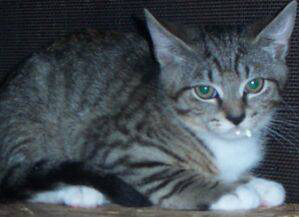

In [3]:
with Image.open('../input/dogs-cats-images/dataset/test_set/cats/cat.4040.jpg') as im:
    display(im)

In [4]:
root_path = '../input/dogs-cats-images/dataset'
img_names = []

for folder, subfolder, filenames in os.walk(root_path):
    for img in filenames:
        img_names.append(folder+'/'+img)
print(f"Images: {len(img_names)}")

Images: 10000


In [5]:
img_sizes = []
rejected = []
for item in img_names:
    try:
        with Image.open(item) as img:
            img_sizes.append(img.size)
    except:
        rejected.append(item)
print(f"Images:  {len(img_sizes)}")
print(f"Rejects: {len(rejected)}")

Images:  10000
Rejects: 0


In [6]:
df = pd.DataFrame(img_sizes)
df.head()
        

,0,1
0,221,377
1,242,414
2,499,375
3,499,375
4,499,375


In [7]:
df[0].describe()

count    10000.000000
mean       403.978900
std        108.787373
min         57.000000
25%        322.000000
50%        446.500000
75%        499.000000
max       1050.000000
Name: 0, dtype: float64

In [8]:
df[1].describe()

count    10000.000000
mean       360.521400
std         96.963127
min         33.000000
25%        300.000000
50%        374.000000
75%        422.000000
max        768.000000
Name: 1, dtype: float64

In [9]:
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [10]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.Resize(500),
    transforms.CenterCrop(500),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                          [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(500),
    transforms.CenterCrop(500),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                          [0.229, 0.224, 0.225])
])

In [11]:
train_data = datasets.ImageFolder(os.path.join(root_path, 'training_set'), transform= train_transform)
test_data = datasets.ImageFolder(os.path.join(root_path, 'test_set'), transform= test_transform)

train_loader = DataLoader(train_data, batch_size= 10, shuffle= True, pin_memory= True)
test_loader = DataLoader(test_data, batch_size= 10, shuffle= False, pin_memory= True)

class_names = train_data.classes

print(class_names)
print(f'Training images available: {len(train_data)}')
print(f'Testing  images available: {len(test_data)}')

['cats', 'dogs']
Training images available: 8000
Testing  images available: 2000


In [12]:
class CNN_model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.conv3 = nn.Conv2d(16, 24, 3, 1)
        
        self.fc1   = nn.Linear(60*60*24, 300)
        self.fc2   = nn.Linear(300, 200)
        self.fc3   = nn.Linear(200, 2)
            
    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        
        X = F.relu(self.conv3(X))
        X = F.max_pool2d(X, 2, 2)
        
        X = X.view(-1, 60*60*24)
    
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        
        X = F.log_softmax(X, dim= 1)
        return X
    
model = CNN_model().to(dev)

In [13]:
model

CNN_model(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(16, 24, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=86400, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=2, bias=True)
)

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr= 0.001)

In [17]:
import time
str_time = time.time()

epochs = 6

for i in range(epochs):
    for b, (X_train, y_train) in enumerate(train_loader):
        X_train, y_train = X_train.to(dev), y_train.to(dev)
        b += 1
        
        y_pred = model(X_train)
        loss   = criterion(y_pred, y_train)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step() 
        
curr_time = time.time()
tot_time = (curr_time - str_time)/60
print(f'Time taken: {tot_time} minutes')

Time taken: 9.371731774012249 minutes


In [18]:
model.eval()

with torch.no_grad():
    correct = 0
    for X_test, y_test in test_loader:
        X_test, y_test = X_test.to(dev), y_test.to(dev)
        y_val = model(X_test)
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()
        
print(f'Test accuracy: {correct.item()}/{len(test_data)} = {correct.item()*100/(len(test_data)):7.3f}%')

Test accuracy: 1587/2000 =  79.350%
